## Accumulate Local Effects (ALE) Documentation

This notebook demonstrates how to use `skexplain` to compute 1D or 2D ALE and plot the results. ALE can be used to assess feature importance, feature attributions, and feature interactions. The concept and calculation of ALE is too much to cover in this notebook. We highly recommend readers to check out [Christoph Molnar's chapter on ALE](https://christophm.github.io/interpretable-ml-book/ale.html). 

In [1]:
import sys, os 
sys.path.insert(0, os.path.dirname(os.getcwd()))

In [2]:
import skexplain
import plotting_config
import itertools

In [3]:
### Loading the training data and pre-fit models 
estimators = skexplain.load_models()
X,y = skexplain.load_data()
# if any features are categorical, set the type and MintPy will calculate
# the categorical ALE. 
X = X.astype({'urban': 'category', 'rural':'category'})

## Computing 1D ALE

The following computes the 1D ALE curves for the features given. The arguments are as follows:
* `features`, a single feature or list of features to compute the 1D ALE for. Can also set to `'all'` to compute for all features in the dataframe. 
* `n_bootstrap`, number of bootstrap iterations to re-compute the 1D ALE to provide confidence intervals
* `subsample`, can be a float between 0-1 or an integer, which is interpreted as the percentage of examples or exact number of random samples to use, respectively. 
* `n_jobs`, number of processor to run the script on.
* `n_bins`, interger, the number of bins to compute the ALE. The bins are not evenly-spaced, but based on percentiles to ensure that a similar number of examples exist in each bin. Recommended to using 20-30 bins. However, highly skewed data may not be divisable into more than 15-20 bins. This issue is handled internally by `skexplain`. 

For the ALE calculations, there is an accompanying `tqdm` bar showing the computation progress.  Since the computation are relatively quick, we find it best to compute the ALE for all features for three models up front.  

In [4]:
explainer = skexplain.ExplainToolkit(estimators,X=X, y=y,)

The results are stored as an `xarray.Dataset`. These results can be stored as compressed netcdf files using built-in functions (see load_results in ExplainToolkit). 

### Plotting a single 1D ALE curve 

To plot ALE, we send in the ale_ds from explainer.ale and the list of features to plot. There are additional arguments, but that is discussed below.  


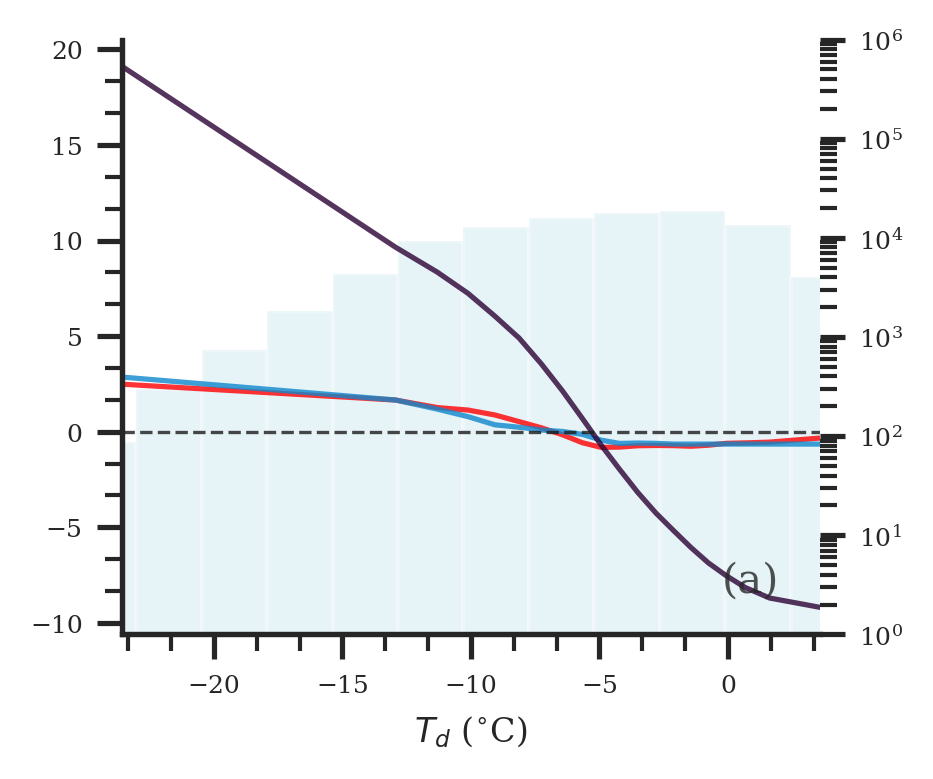

In [9]:
fig, ax = explainer.plot_ale(
                                   ale = ale_1d_ds, 
                                   features='dwpt2m',
                                   display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                  )

By default, scikit-explain is built for scientific publications and will provide figure labels (e.g., see the (a) in the lower right). To avoid this, the users can provide their own matplotlib Axes object. 

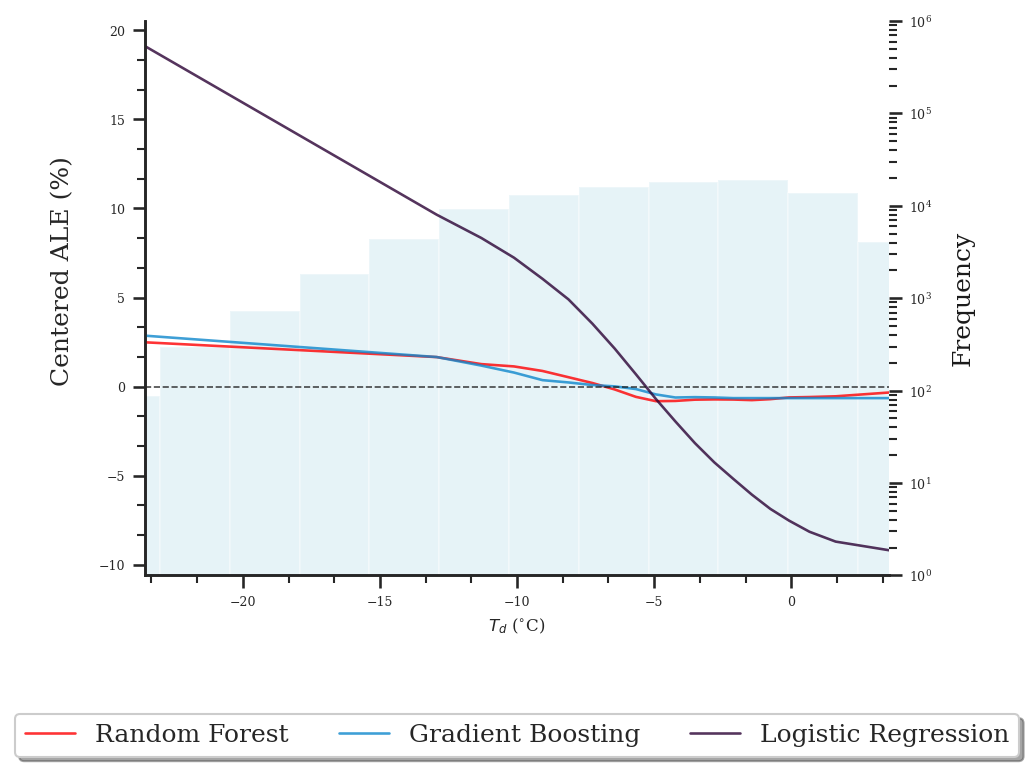

In [10]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(dpi=150)
fig, ax = explainer.plot_ale(
                                   ale = ale_1d_ds, 
                                   features='dwpt2m',
                                   display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                    ax=ax
                                  )

### Plotting 1D ALE for the top features 
To limit the scope of our analysis, we can start by plotting the ALE for the most important features. Assuming we have already run the permutation importance, we can pass those into `.get_important_vars`. If we are using multiple models, we can set `combine=True` and this function will make a single list of important predictors (removing duplicates). From this single list, we can ask for only a subset of features (`n_vars=7`). Otherwise, the function will return a dict with the model names as keys with the top features as items. 

To personalize your plots, you can pass a dict `display_feature_names`, which should map the feature names with a prettier, more interpretable name. To see our example of `display_feature_names`, look in `plotting_config.py`. Note that once you develop your own mapping dictionary, it can be used throughout the skexplain plotting suite. 

In [6]:
# Load the permutation important results from the saved pickle file
results = explainer.load(fnames='../tutorial_data/multipass_importance_naupdc.nc',)

# We can use a bulit-in function that will extract the top predictors from all the model
# remove any duplicate features to produce a single list. In this case, we want the top 7 features
important_vars = explainer.get_important_vars(results, multipass=True, n_vars=100, combine=True)

Though skexplain will attempt to automate the plotting, users do have some options to correct the plotting or customize it. For example, you can pass the `hspace` or `wspace` arguments to the various plotting scripts with skexplain to customize the space between plots (see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots_adjust.html for more information).

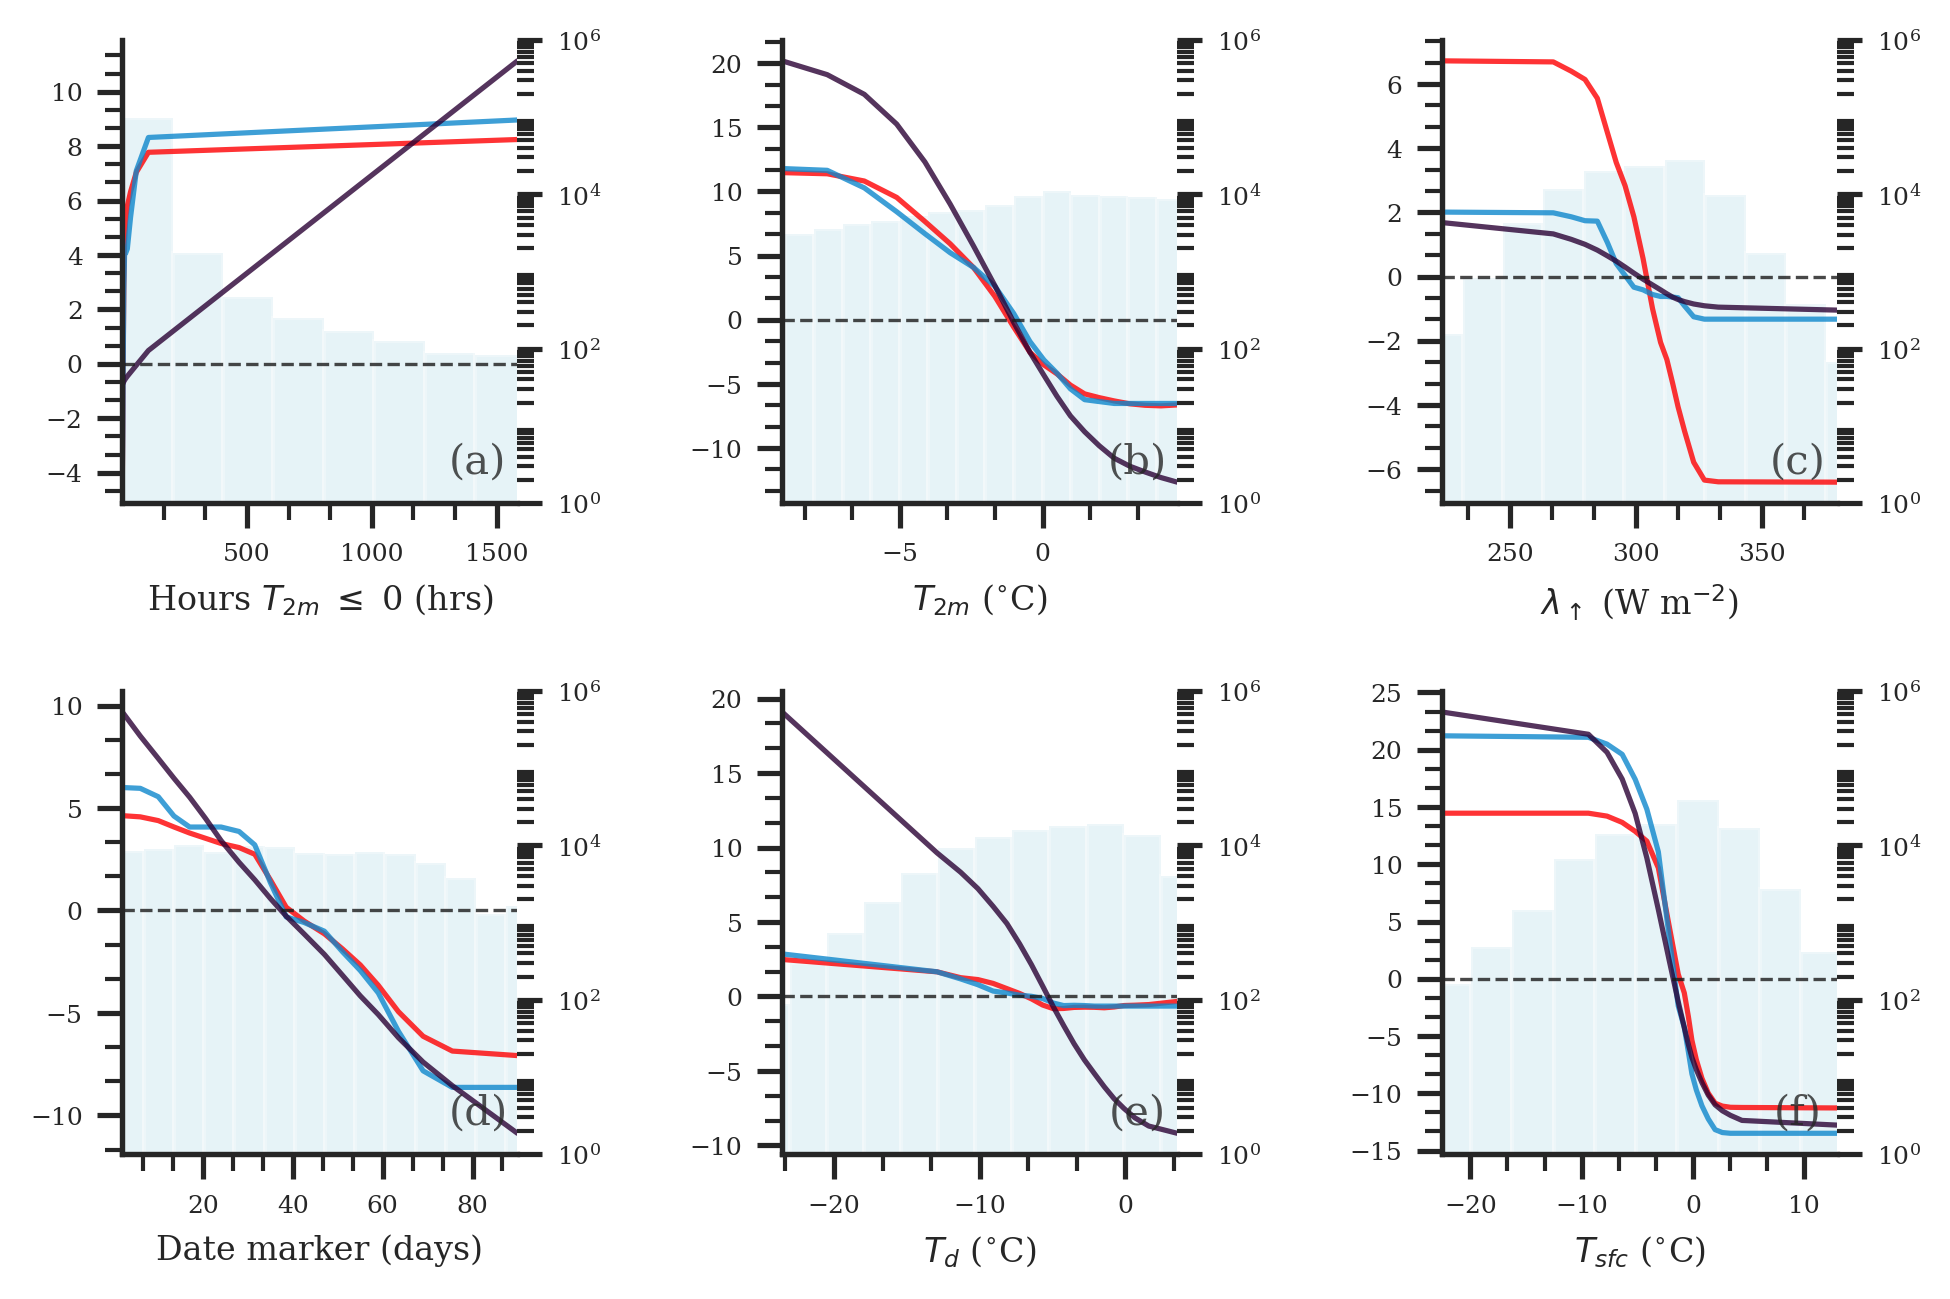

In [7]:
fig, axes = explainer.plot_ale(
                                   ale = ale_1d_ds, 
                                   features=important_vars,
                                   display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                  )

The light blue histogram in the background is the distribution of values the ALE was computed over. In instances where the distribution is poorly sampled, we should have less confident in the ALE value. The ALE value for a particular feature value is interpreted as the expected feature contribution. For example, the generic feature attribution equation is: 
\begin{equation}
p = \mathbb{E}(f_i) + \sum_i^{N} f_i
\end{equation}
where $p$ is the prediction, $f_i$ is the contribution from the $i$-th feature (of which there are $N$), and \mathbb{E}(f_i) is typical equal to $(1/N)\sum_i^{N} f_i$. In panel (e), when the 2-m temperature ($T_{2m}$) is below 0$^{\circ}$C, the expected contribution is increasingly negative, varying between -6 to -12%, depending on the model. This is a sanity check as one would expect that cooler surface temperatures to be associated with freezing road surfaces. The large range of expected contributions from both 2-m temperature and surface temperature (panels d and e) also help explain why they were the top-most important features (see the [permutatation importance notebook](https://github.com/monte-flora/mintpy/blob/master/tutorial_notebooks/permutation_importance_tutorial.ipynb) ).

### Modifying colors and properties of the ALE curves and background histogram

Users do not have to use the default colors in `scikit-explain`. Using the `line_kws` arg, you can pass in `line_colors` to change the line colors and using  `hist_color` to change background histogram color. Using `line_kws`, you can send in valid keyword arguments for [matplotlib.axes.Axes.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html)(e.g., linewidth, linestyle, etc.)  

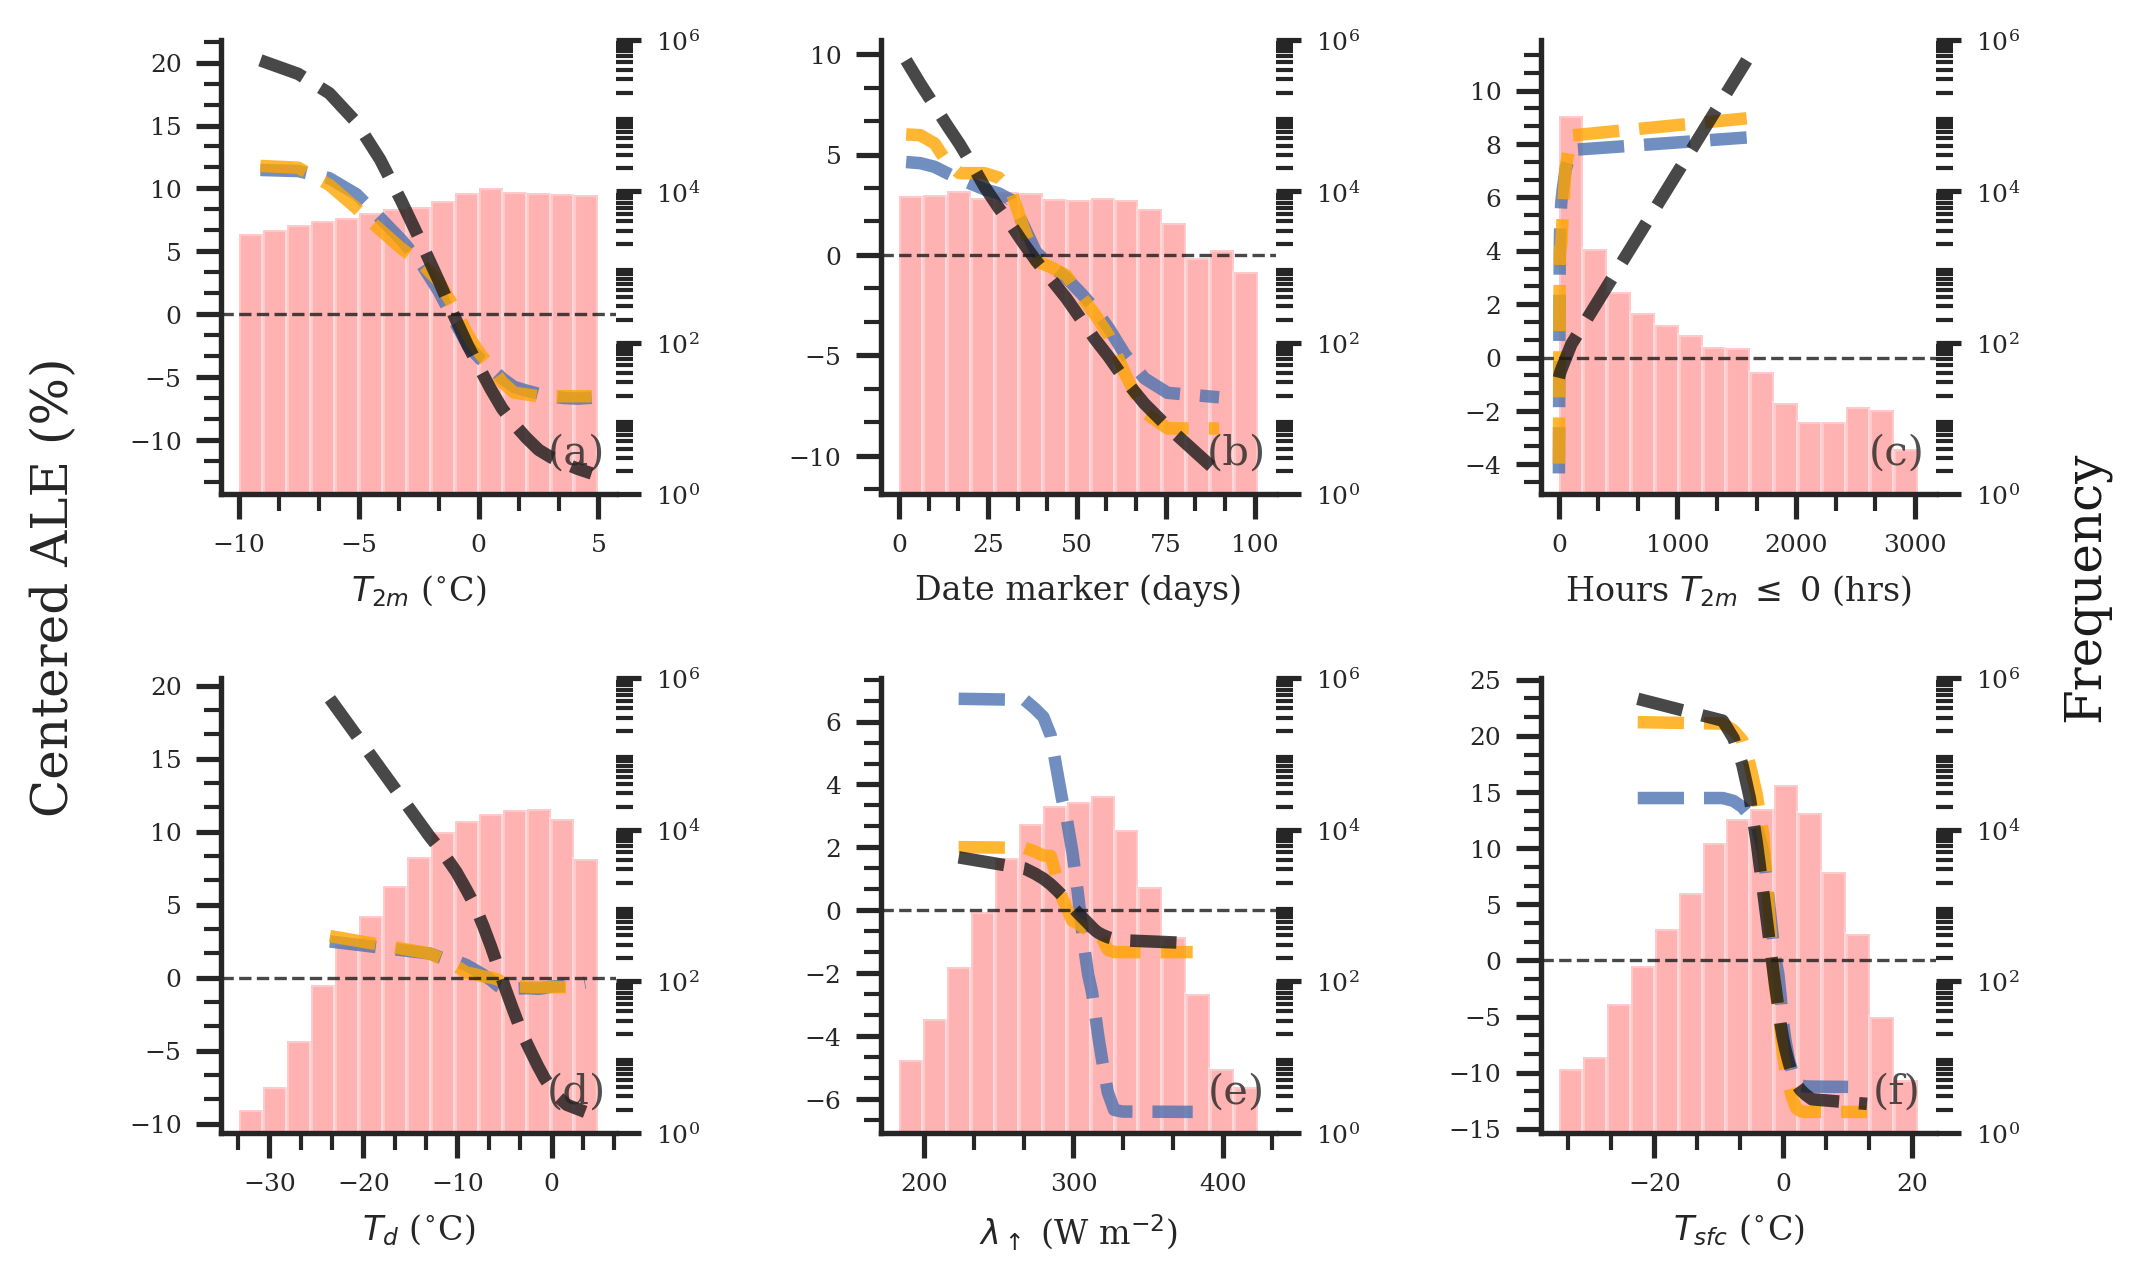

In [9]:
fig, axes = explainer.plot_ale(
                                   ale=ale_1d_ds, 
                                   features=important_vars,     
                                   display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                   line_kws = {'line_colors' : ['b', 'orange', 'k'], 'linewidth' : 3.0, 
                                               'linestyle' : 'dashed'
                                              },
                                    hist_color = 'red',
                                  )

### Using bootstrapping for confidence intervals

A crucial aspect of statistical analysis is providing uncertainty estimates. In skexplain, we use bootstrapping to provide confidence intervals for ALE. The uncertainty in ALE also carries over to other ALE-based statistics (interation strength, main effect complexity, etc.) 

  0%|          | 0/18 [00:00<?, ?it/s]

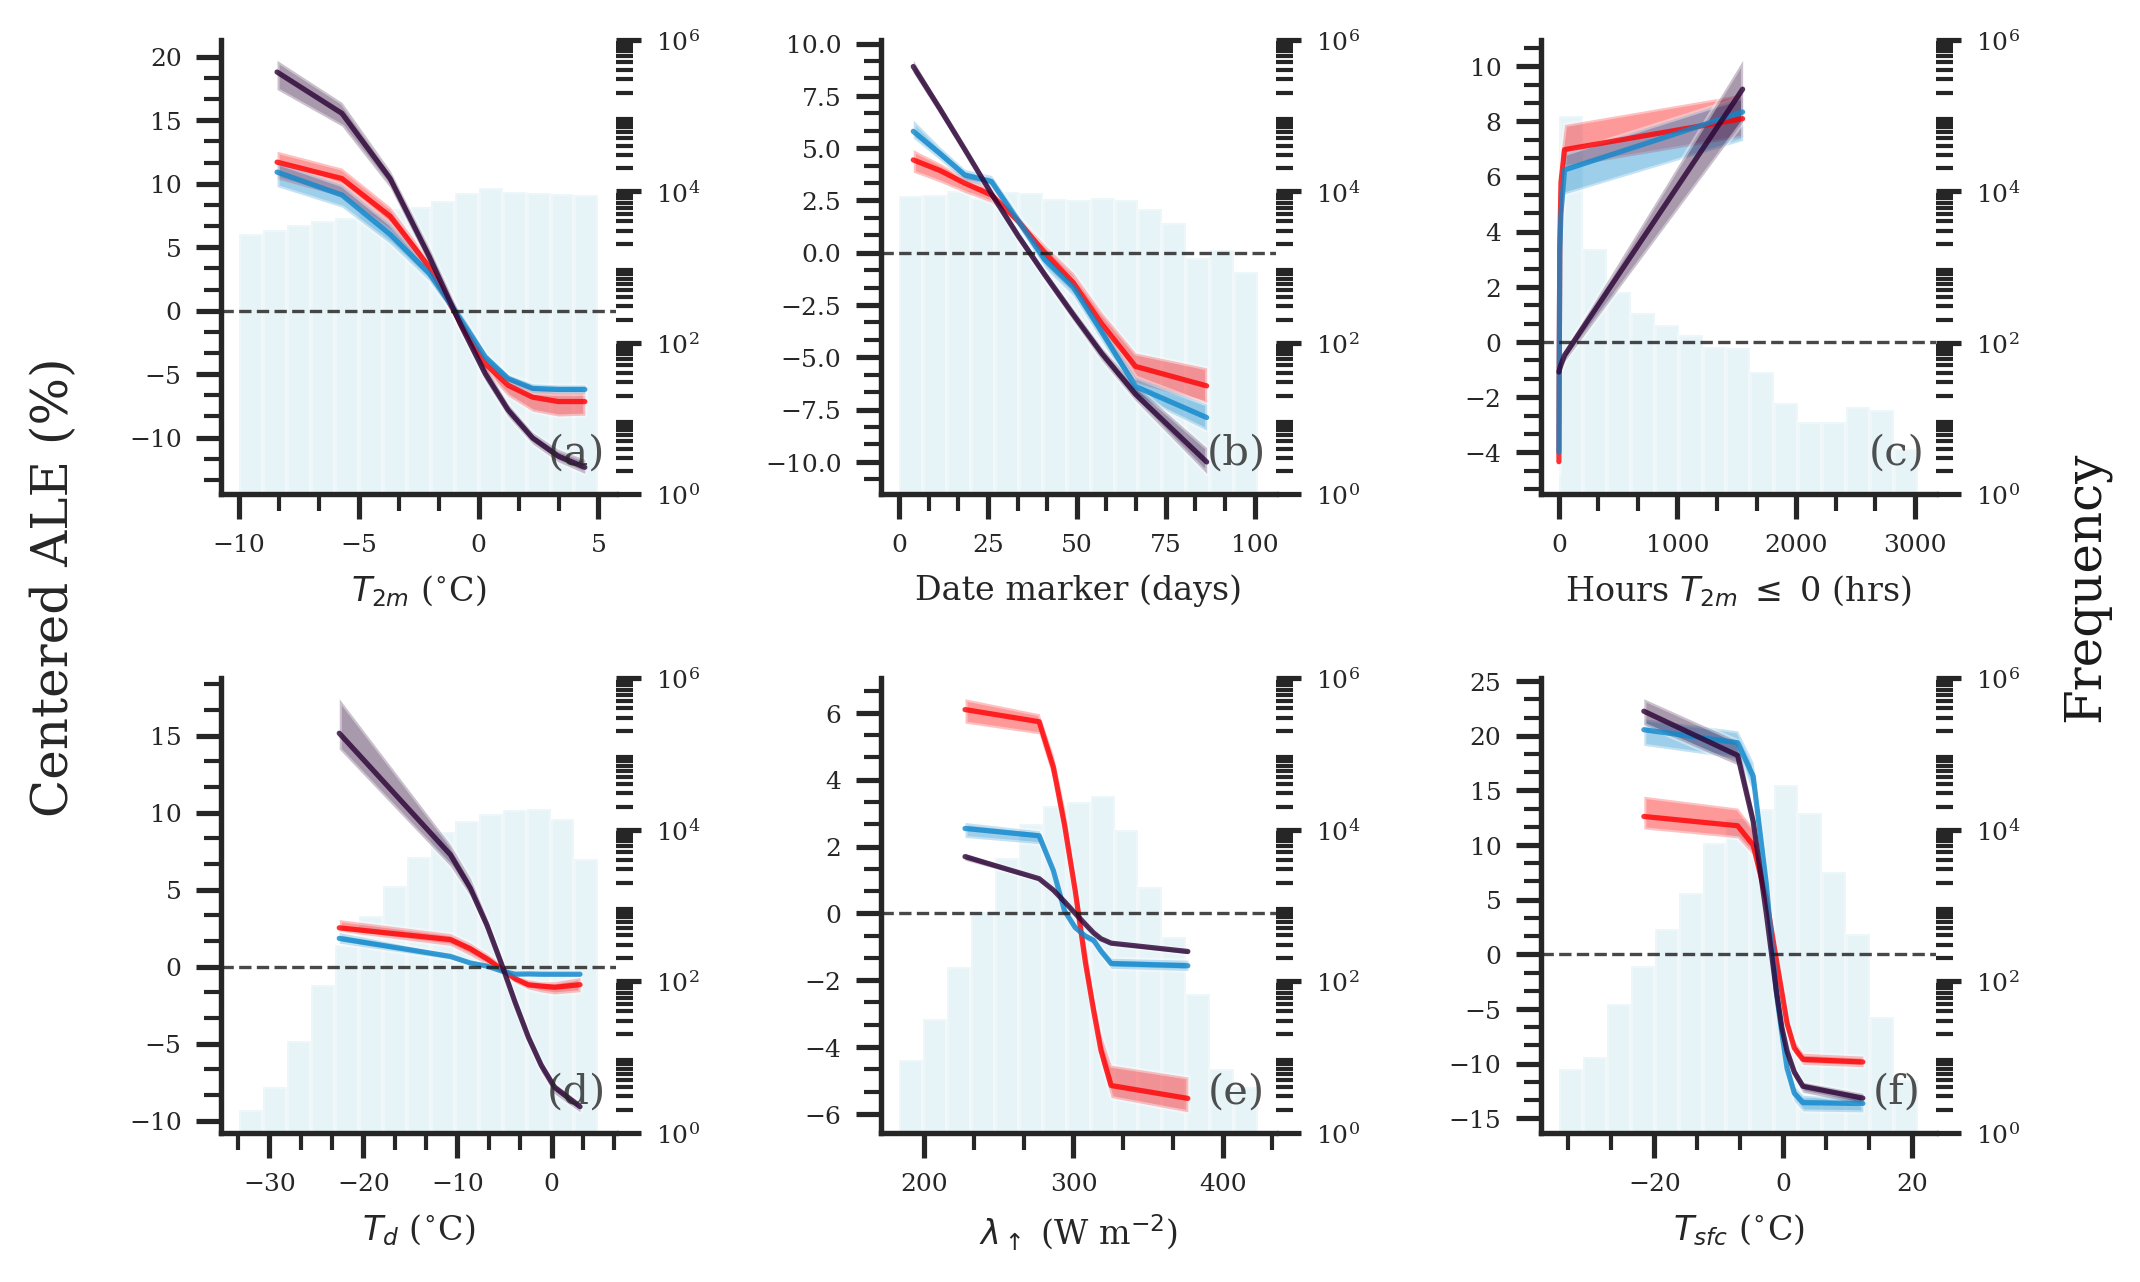

In [10]:
ale_1d = explainer.ale(features=important_vars, 
                          n_bootstrap=10, 
                          subsample=1000, 
                          n_jobs=4, 
                          n_bins=10
                                )
fig, axes = explainer.plot_ale(
                               ale=ale_1d,
                               display_units=plotting_config.display_units,
                                display_feature_names=plotting_config.display_feature_names,
)

Note that these confidence intervals are NOT equivalent to the uncertainty in the main effect, which is provided by the ICE curves (see next box). The confidence intervals are simply the uncertainty in the mean value. 

## Adding Individual Conditional Expectation (ICE) curves 

The ALE curves attempt to estimate the first-order or main effect of a given feature. However, if the ML model is not purely additive and contains feature interactions (e.g., $\beta x_1x_2$), then the first-order effects are often higher dimensional. However, the ALE curves is only the expected contribution (the mean value) and will require dimensionality reduction if feature interactions are present. If the reader is unaware of ICE curves, we highly recommend reading the following chapter: https://christophm.github.io/interpretable-ml-book/ice.html.

In this example, we will compute the ICE curves for only the random forest. To compute ICE curves, we call `.calc_ice`. The main argument for the ICE curves is the subsample size. Plotting more than 100-200 curves can make the plot hard to interpret, so we set the size at 200. 

In [11]:
ice_ds = explainer.ice( features=important_vars,  subsample=200, n_jobs=4, n_bins=10)

  0%|          | 0/18 [00:00<?, ?it/s]

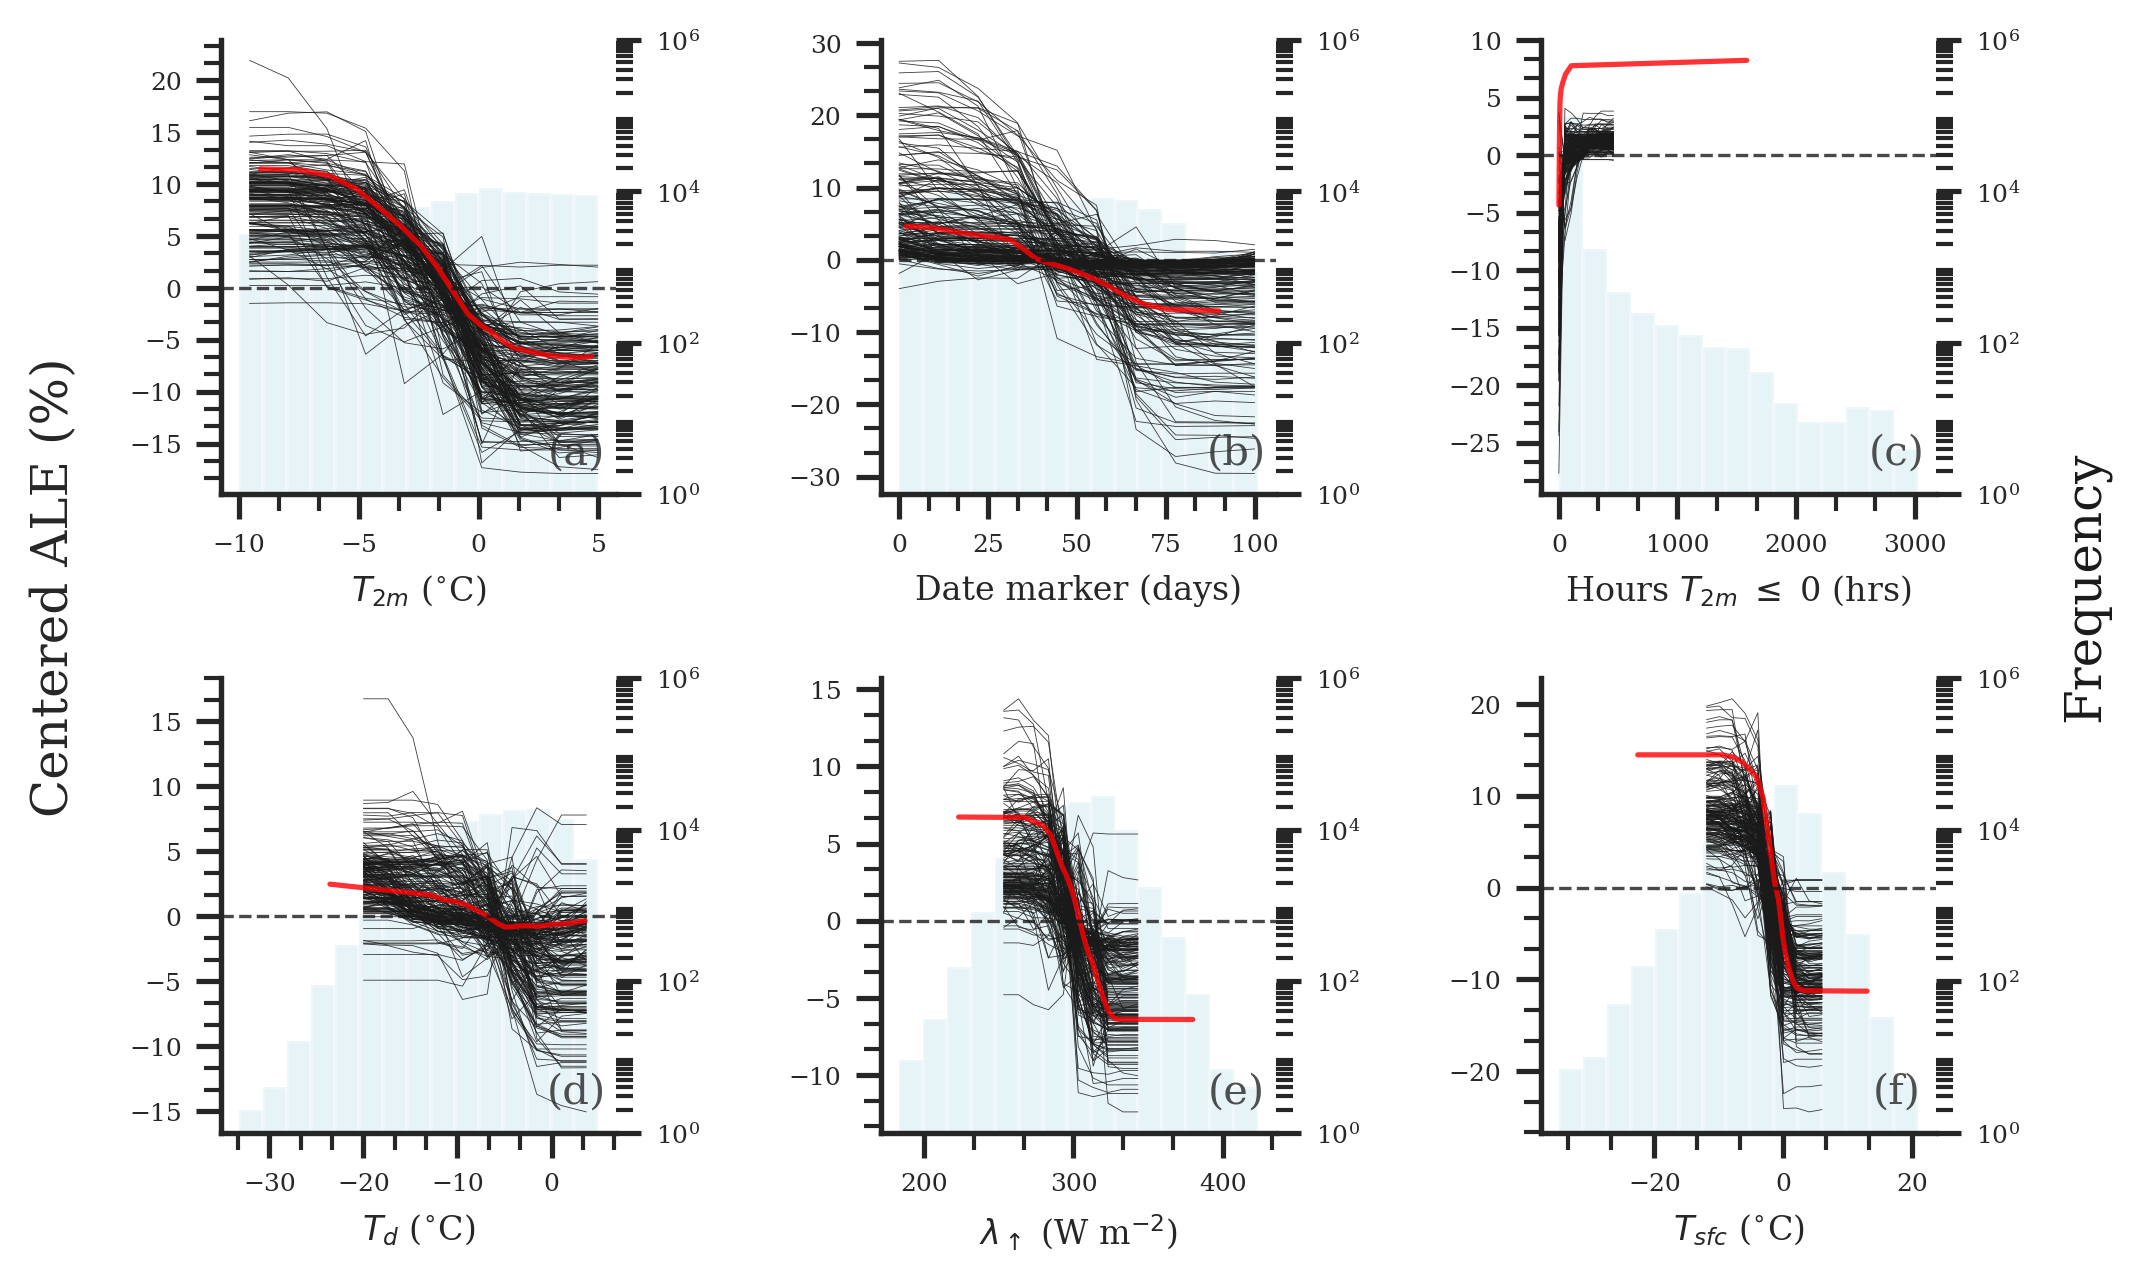

In [12]:
fig, axes = explainer.plot_ale(
                               ale=ale_1d_ds,
                               estimator_names = 'Random Forest', 
                               display_units=plotting_config.display_units,
                               display_feature_names=plotting_config.display_feature_names,
                               ice_curves=ice_ds, 
                                  )

ICE curves are a permutation-based method and therefore assume feature dependence. Therefore, when we have dependent features, it can muddle our interpretation. The general idea, however, is that the spread in the ICE curves about the expected contribution indicates feature interactions. Strong feature interactions produce greater variation in the ICE curves. 

## Computing and Plotting 2D ALE 

The previous examples showed the 1D ALE curves. It is also possible to compute the ALE between two features. In this case, we are measuring the additional contribution from the combination of the two features (minus their respective 1D effects). If there is no multiplicative feature interactions between two features in a model, then the 2D ALE is zero everywhere. 

In [4]:
features=[('temp2m', 'sfc_temp'), ('dwpt2m', 'sfc_temp'), ('temp2m', 'dwpt2m')]

  0%|          | 0/9 [00:00<?, ?it/s]

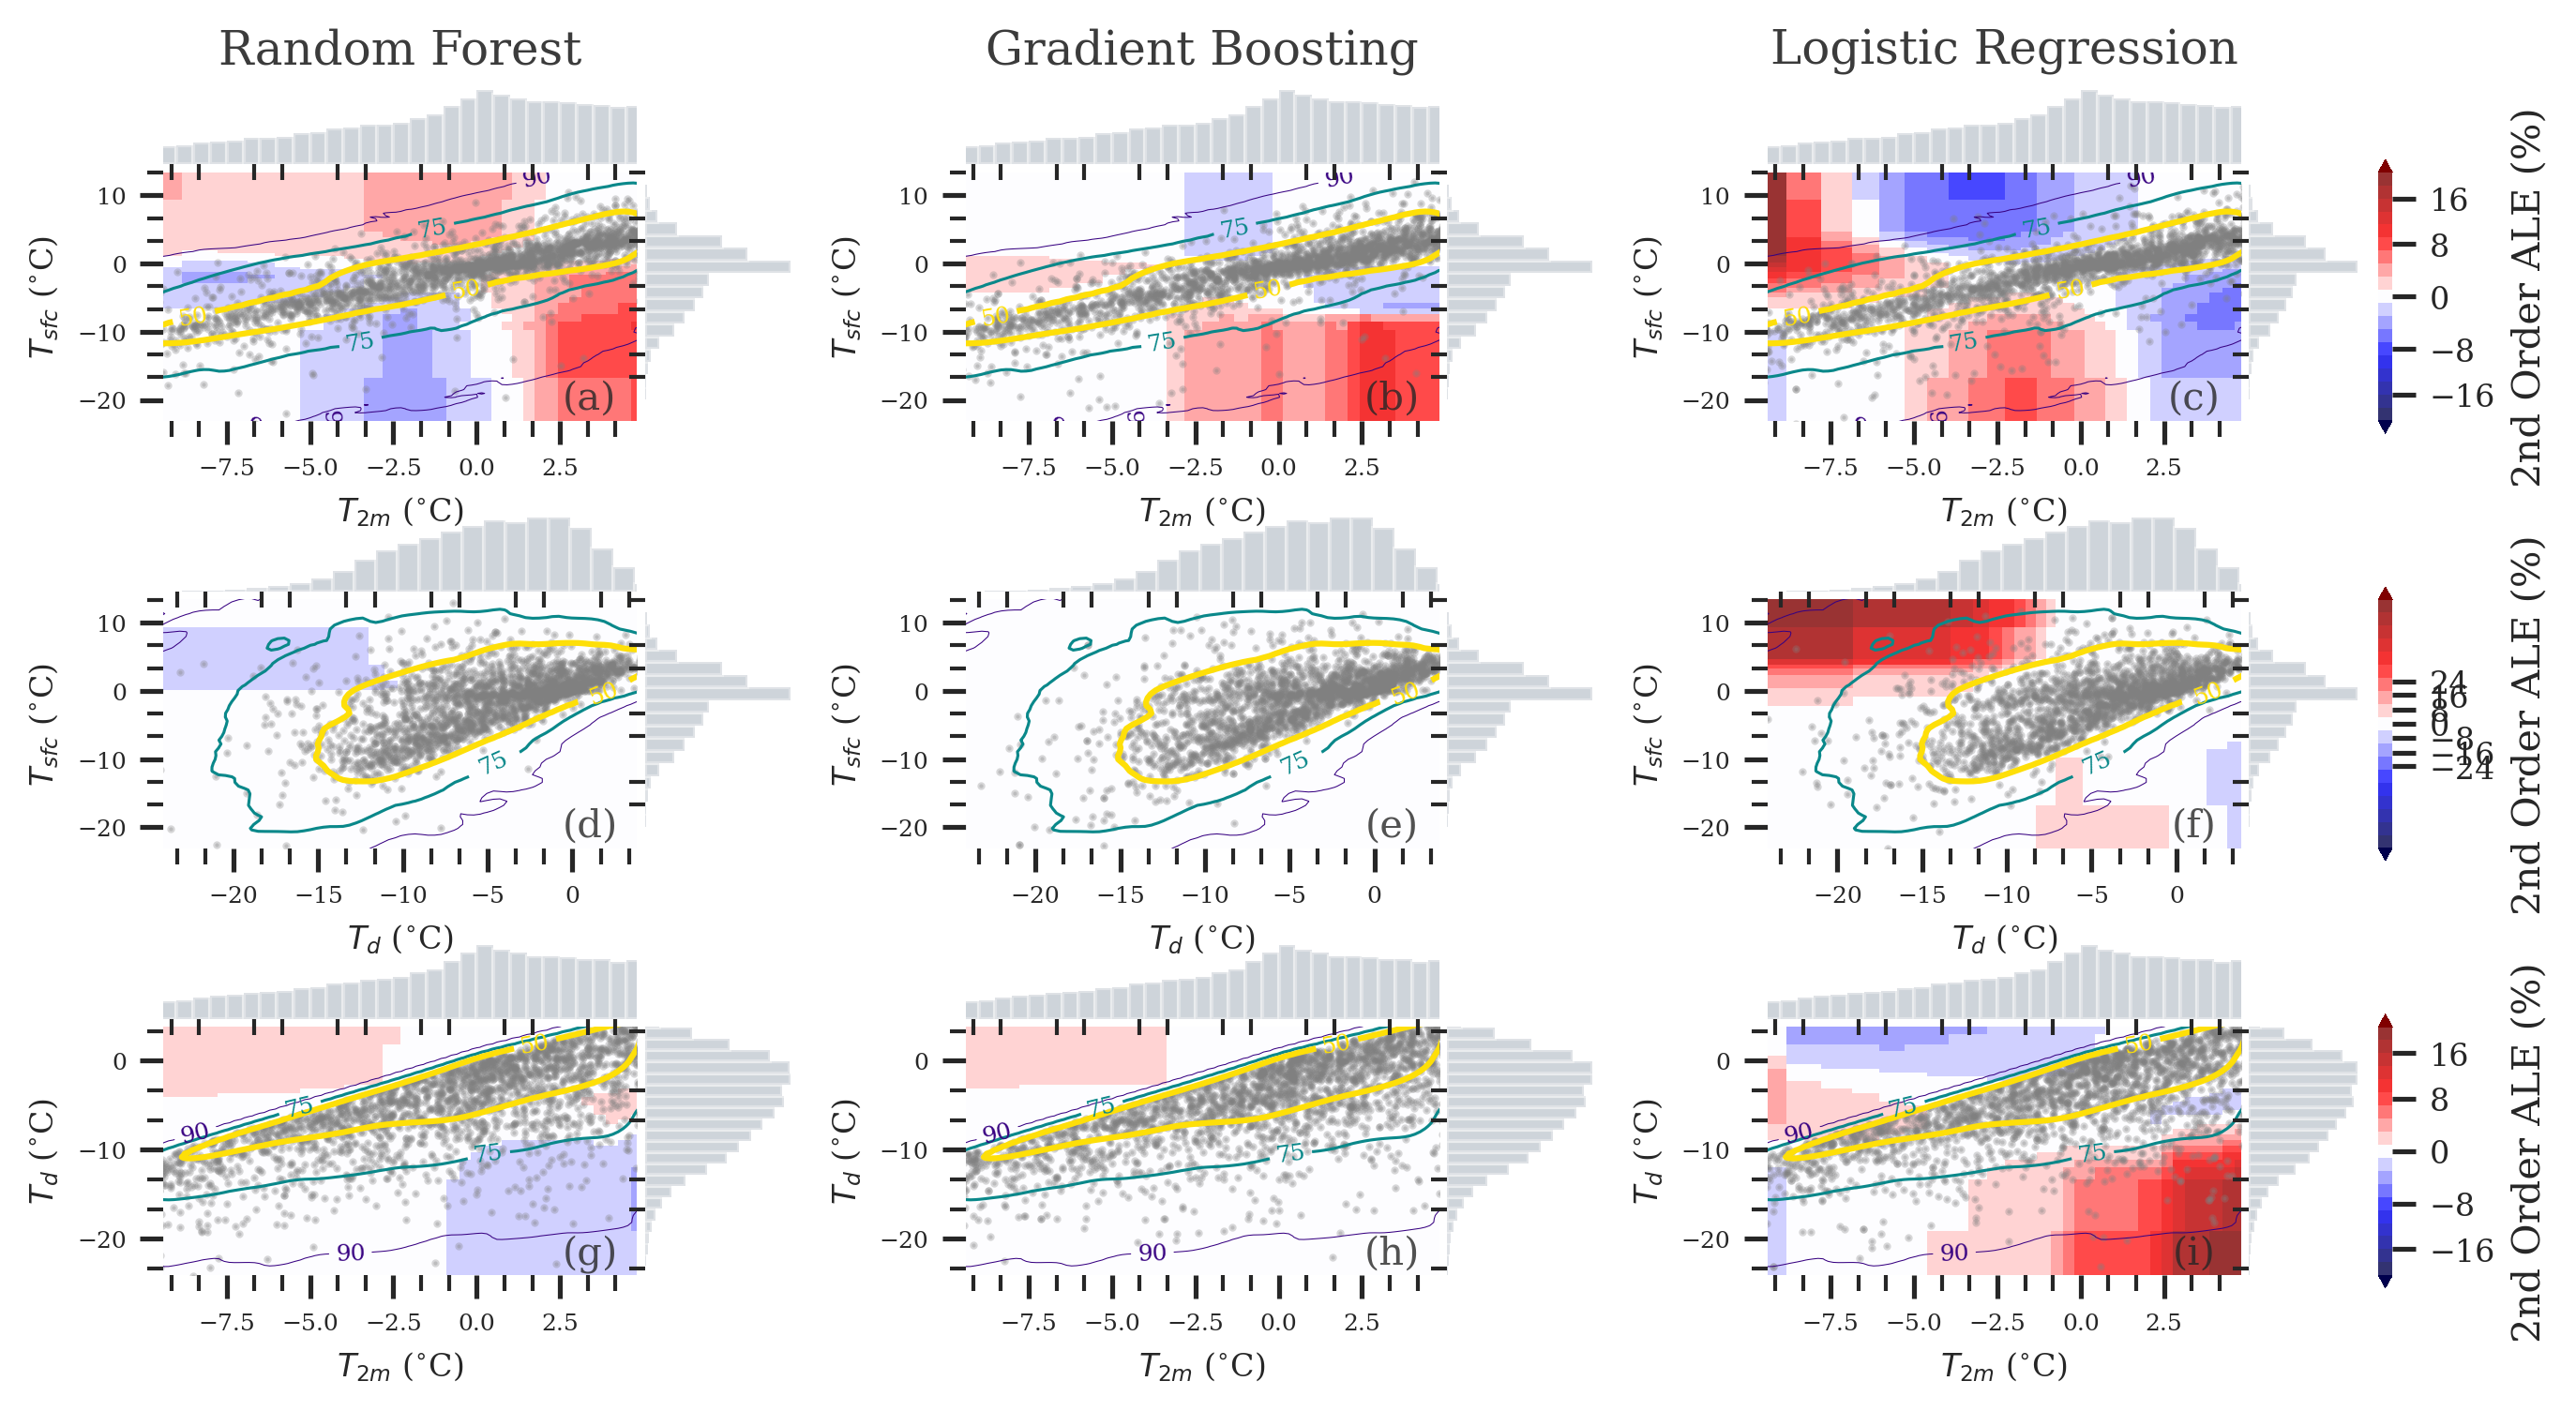

In [13]:
explainer = skexplain.ExplainToolkit(estimators, X=X, y=y,)
ale_2d_ds = explainer.ale(features=features, 
                                 n_bootstrap=1, 
                                 subsample=1.0,
                                 n_jobs=len(features)*len(estimators),
                                 n_bins=30
                                )

fig, axes = explainer.plot_ale(ale=ale_2d_ds,
                                   display_units=plotting_config.display_units,
                                   display_feature_names=plotting_config.display_feature_names,
                                  )

In these plots, 
* The marignal distribution of the two features are shown in each panel
* A subsample of the actual data is shown as dots 
* The kernal density estimate of the dots is overlaid. 

The additional overlays can be turned on or off by passing in the appropriate arguments. 

## Using ALE for interaction effects 

We can compute the second-order ALE and then use the concept from [Greenwell et al. (2018)](https://arxiv.org/abs/1805.04755) (see Section 3.2).  In this case we are using the purely second-order ALE rather than the second-order PD. For this example, we will compute the second-ALE for every combination of the most important predictors. We can use same `.calc_ale_variance` call, but set `interaction=True`. We can also use the same `.plot_importance` and in this case set `method='ale_variance_interactions`.

In [8]:
ale_2d_ds = explainer.ale(features=features, 
                                 n_bootstrap=1, 
                                 subsample=1.0, 
                                 n_jobs=6, 
                                 n_bins=30
                                )

  0%|          | 0/9 [00:00<?, ?it/s]

In [9]:
ale_var_2d = explainer.ale_variance(ale=ale_2d_ds, features=features, interaction=True)

In [10]:
ale_var_2d['ale_variance_interactions_rankings__Gradient Boosting']

<xarray.DataArray 'ale_variance_interactions_rankings__Gradient Boosting' (
                                                                           n_vars_ale_variance_interactions: 3)>
array(['temp2m__sfc_temp', 'temp2m__dwpt2m', 'dwpt2m__sfc_temp'],
      dtype='<U16')
Dimensions without coordinates: n_vars_ale_variance_interactions

(<Figure size 1800x750 with 5 Axes>,
 array([<AxesSubplot:title={'center':'Logistic Regression'}>,
        <AxesSubplot:title={'center':'Gradient Boosting'}>,
        <AxesSubplot:title={'center':'Random Forest'}>], dtype=object))

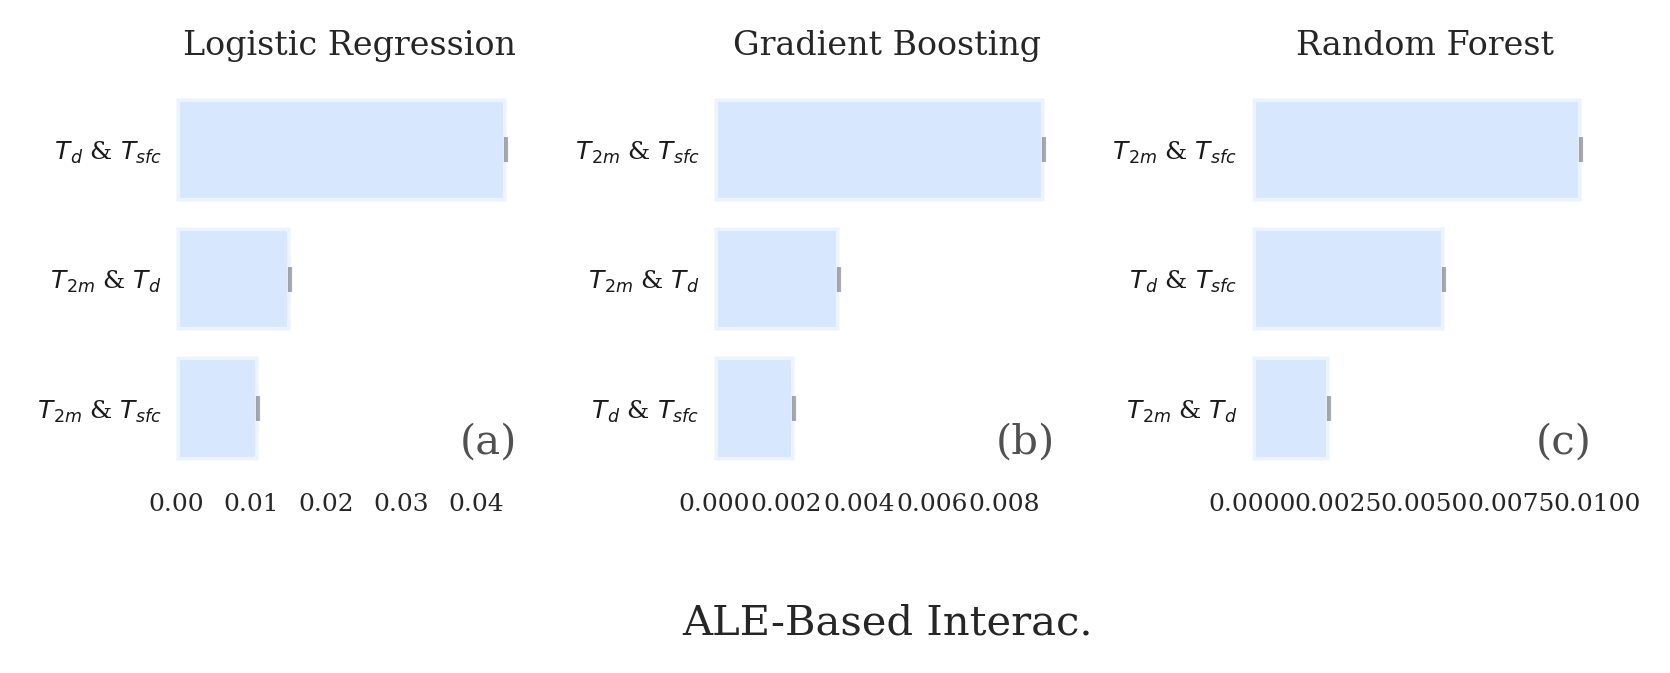

In [11]:
adict = plotting_config.display_feature_names
display_feature_names = {f'{f[0]}__{f[1]}': f'{adict[f[0]]} & {adict[f[1]]}' 
                         for f in features}

explainer.plot_importance(
                              data=[ale_var_2d]*3,
                              panels=[('ale_variance_interactions', 'Logistic Regression'),
                                      ('ale_variance_interactions', 'Gradient Boosting'),
                                      ('ale_variance_interactions', 'Random Forest')
                                     ], 
                              num_vars_to_plot=15,
                              display_feature_names=display_feature_names,
                             )

A crucial component of this plot is setting `plot_correlated_features=True`. In this case, features with a linear correlation coefficient > 0.8 are color-coded. We can disregard the ranking of those pairs as the 2D ALE will tend to over-predict the ALE for correlated pairs. Otherwise, we can see an important pairing between number of hours the 2-m temperature is below zero and the current 2-m temperature. Unfortunately, it is not clear whether the Interaction Importance is significantly different from zero, which muddles our analysis. 

## Using ALE to compute overall interaction strength 

From [Molnar et al. 2019](https://arxiv.org/abs/1904.03867), any high-dimensional prediction function (i.e., an ML model) can be decomposed as a sum of components with increasing dimensionality:
\begin{equation}\label{eqn:ale_decompose}
    f(x) = \overbrace{f_0}^{\text{Intercept}} + \overbrace{\sum_{j=1}^{P} f_j (x_j)}^{\text{1st order effects}} +  \overbrace{\sum_{j<k}^{P} f_{jk} (x_j,x_k)}^{\text{2nd order effects}} + ... + \overbrace{f_{1,...,P}(x_{1,...,P}}^{\text{P-th order effects}}),
\end{equation}
Using this concept, we can approximate an ML model as its average model prediction, the first-order ALE, and all second-order or higher effects characterized as the measure of interaction strength (IAS; [Molnar et al. 2019](https://arxiv.org/abs/1904.03867); denoted by $I(x)$): 
\begin{equation}
    f(x) = \frac{1}{N}\sum_{i=1}^N f(x^{(i)}) + \sum_{j=1}^{P} ALE_j (x_j) + I(x),
\end{equation}
We can define the IAS as an approximation error of the first-order ALE with respect to the original model predictions:
\begin{equation}
    IAS = \frac{\sum_{i=1}^N \Big( f[x^{(i)}] - f_{ALE1st}[x^{(i)}]\Big)^2}{\sum_{i=1}^N \Big( f[x^{(i)}] - f_0\Big)^2},
\end{equation}
where $f_{ALE1st} = f_0 + ALE_1(x_1) +...+ALE_P(x_P)$. If IAS = 0, then a ML model is perfectly approximated by first-order effects and has no predictor interactions. 


In [14]:
ias = explainer.interaction_strength(ale=ale_1d_ds, n_bootstrap=5, subsample=0.1)

  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
ias

<xarray.Dataset>
Dimensions:                  (n_bootstrap: 5)
Dimensions without coordinates: n_bootstrap
Data variables:
    Logistic Regression_ias  (n_bootstrap) float64 0.06123 0.06162 ... 0.05994
    Gradient Boosting_ias    (n_bootstrap) float64 0.07487 0.0793 ... 0.07534
    Random Forest_ias        (n_bootstrap) float64 0.1711 0.1725 ... 0.1736
Attributes:
    estimator_output:  probability
    estimators used:   ['Random Forest', 'Gradient Boosting', 'Logistic Regre...
    method:            ale
    dimension:         1D
    features used:     ['dllwave_flux', 'dwpt2m', 'fric_vel', 'gflux', 'high_...
    estimator output:  probability
    interaction:       True
    evaluation_fn:     Interaction Importance

The IAS values for all three models are fairly low (the highest value is 0.16 for the random forest). The takeaway is that the overall feature interaction strength is fairly weak for all three models and the models are mainly additive, first-order effects. This is positive result as the model will be more interpretable than had the IAS been much higher. 

## Using ALE to compute the main effect complexity 

To describe the shape of the first-order ALE curves, [Molnar et al. 2019](https://arxiv.org/abs/1904.03867) introduced the main effect complexity (MEC) statistic:
\begin{equation}
    \text{MEC} = \frac{1}{\sum_{j=1}^P \sigma^2_{ALE(x_j)}} \sum_{j=1}^{P} \sigma^2_{ALE(x_j)} MEC_j
\end{equation}
where $MEC_j$ is number of line segements needed to approximate the $ALE(x_j)$ curve with a piece-wise linear function and $\sigma^2_{ALE(x_j)}$ is the variance of $ALE(x_j)$. For a fully linear model, MEC = 1 while higher values indicate more complex first-order effects. 

In this example, the logistic regression has "simplier" first-order effects compared to the random forest and gradient-boosted tree.

In [16]:
mec = explainer.main_effect_complexity(ale=ale_1d_ds)

In [17]:
mec

{'Random Forest': 2.439337034684521,
 'Gradient Boosting': 2.554220396177176,
 'Logistic Regression': 1.723482461669565}

Logistic regression has a MEC value of 1.7 while the Random Forest and Gradient Boosting models have a MEC of 2.5. A MEC of 1.7 means that the average ALE curve for the Logistic Regression model can be described with 1.7 line segments. Logistic regression is a linear model, so we would expect it to have simplier first-order effects as compared to the Random Forest and Gradient Boosting models.

## ALE for Regression Problems

In [18]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor

In [19]:
data = fetch_california_housing()
X = data['data']
y = data['target']
feature_names = data['feature_names']
model= RandomForestRegressor()
model.fit(X,y)

RandomForestRegressor()

In [20]:
explainer = skexplain.ExplainToolkit(('Random Forest', model), X=X,y=y,feature_names = feature_names)

  0%|          | 0/8 [00:00<?, ?it/s]

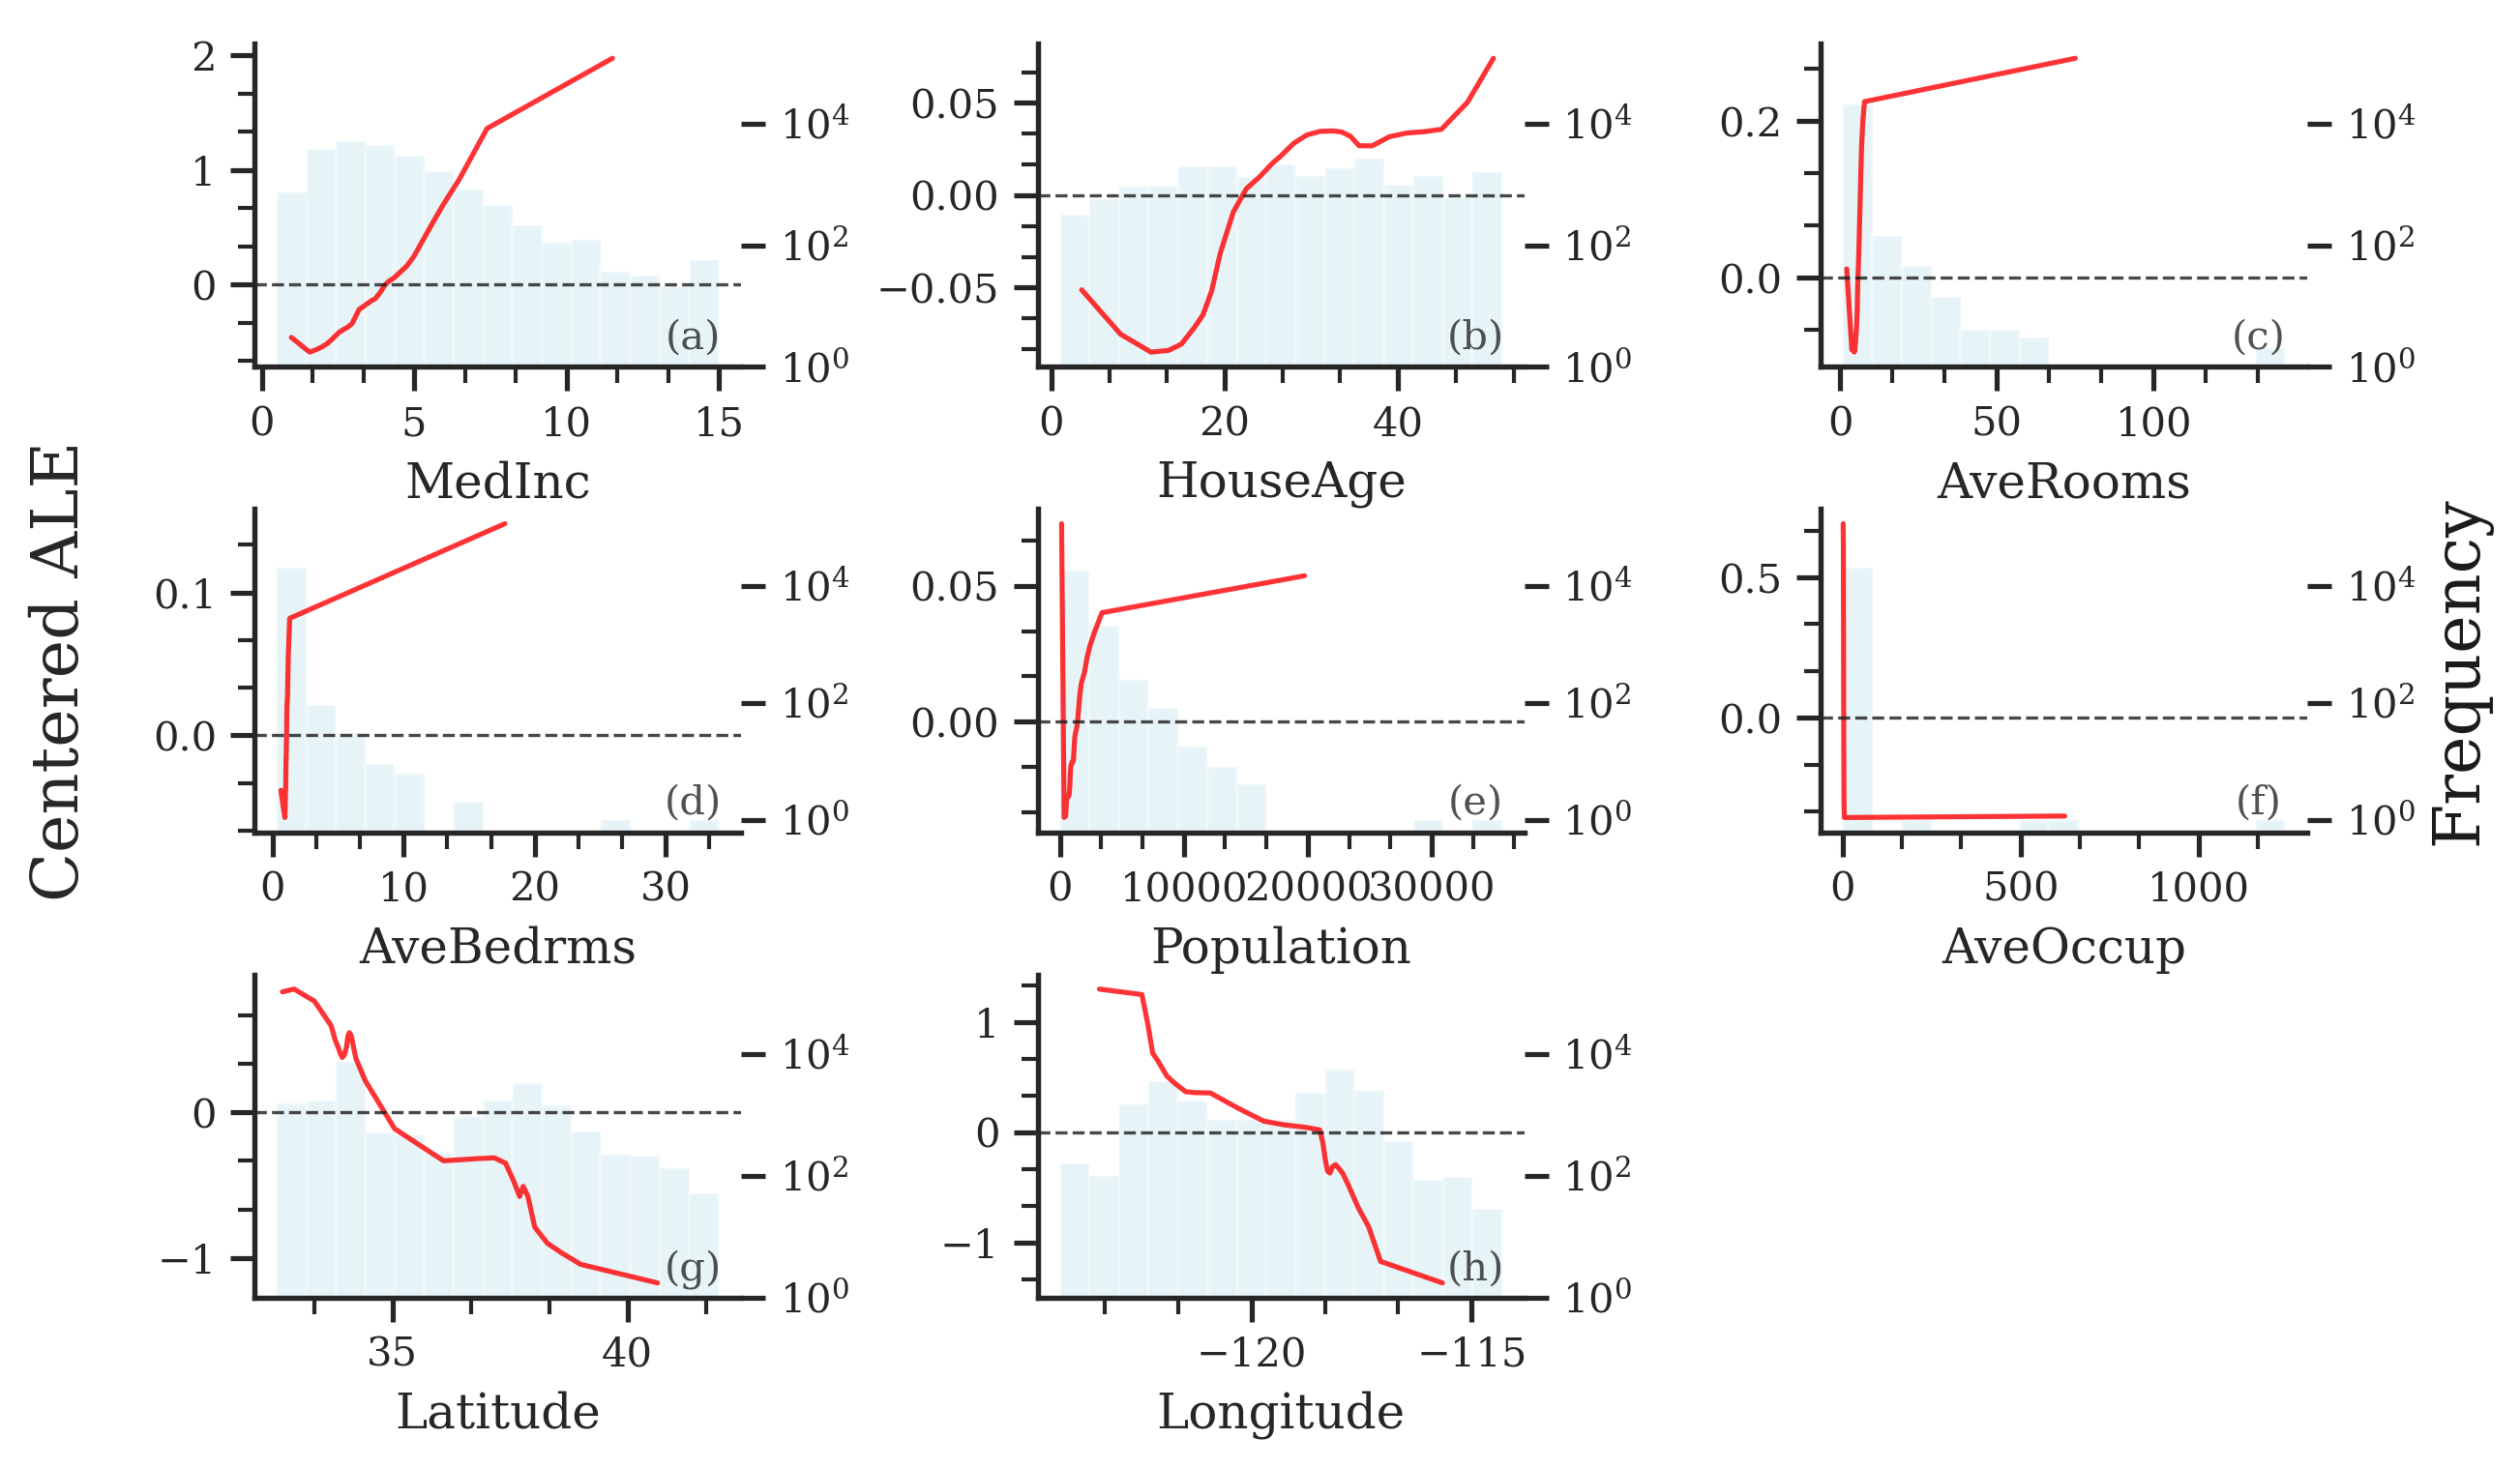

In [21]:
ale_1d_reg = explainer.ale(features=feature_names, 
                                 n_bootstrap=1, 
                                 subsample=10000, 
                                 n_jobs=6, 
                                 n_bins=30
                                )
fig, axes = explainer.plot_ale(ale_1d_reg)

In [22]:
ale_var_1d_reg = explainer.ale_variance(ale_1d_reg)

In [23]:
ale_var_1d_reg['ale_variance_rankings__Random Forest']

<xarray.DataArray 'ale_variance_rankings__Random Forest' (n_vars_ale_variance: 8)>
array(['Longitude', 'Latitude', 'MedInc', 'AveOccup', 'AveRooms',
       'HouseAge', 'AveBedrms', 'Population'], dtype='<U10')
Dimensions without coordinates: n_vars_ale_variance

(<Figure size 900x750 with 3 Axes>, <AxesSubplot:>)

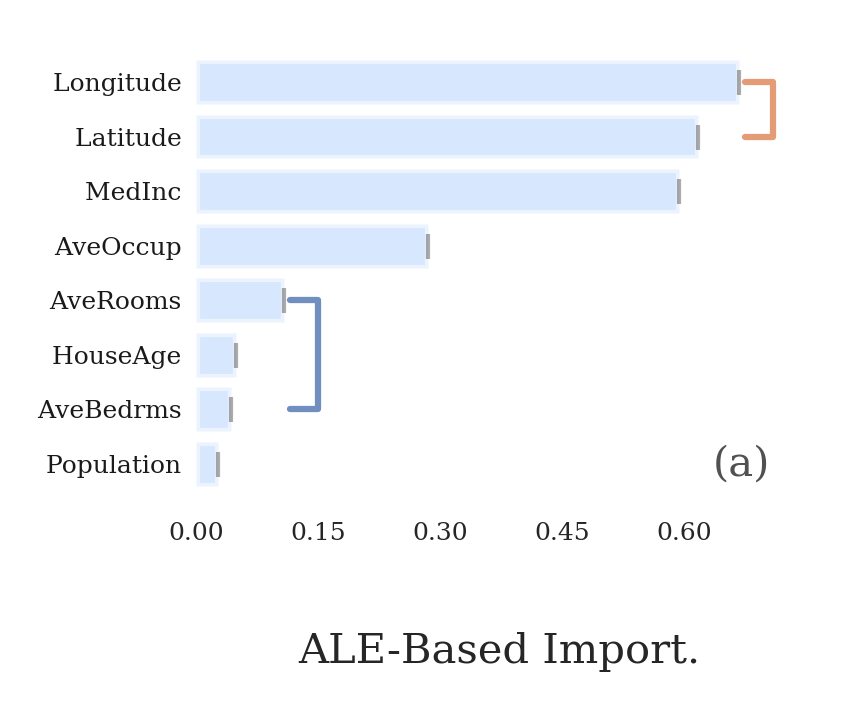

In [24]:
explainer.plot_importance(
                          data=ale_var_1d_reg,
                          panels=[('ale_variance', 'Random Forest')], 
                          num_vars_to_plot=8, 
                          plot_correlated_features=True
                         )

  0%|          | 0/2 [00:00<?, ?it/s]

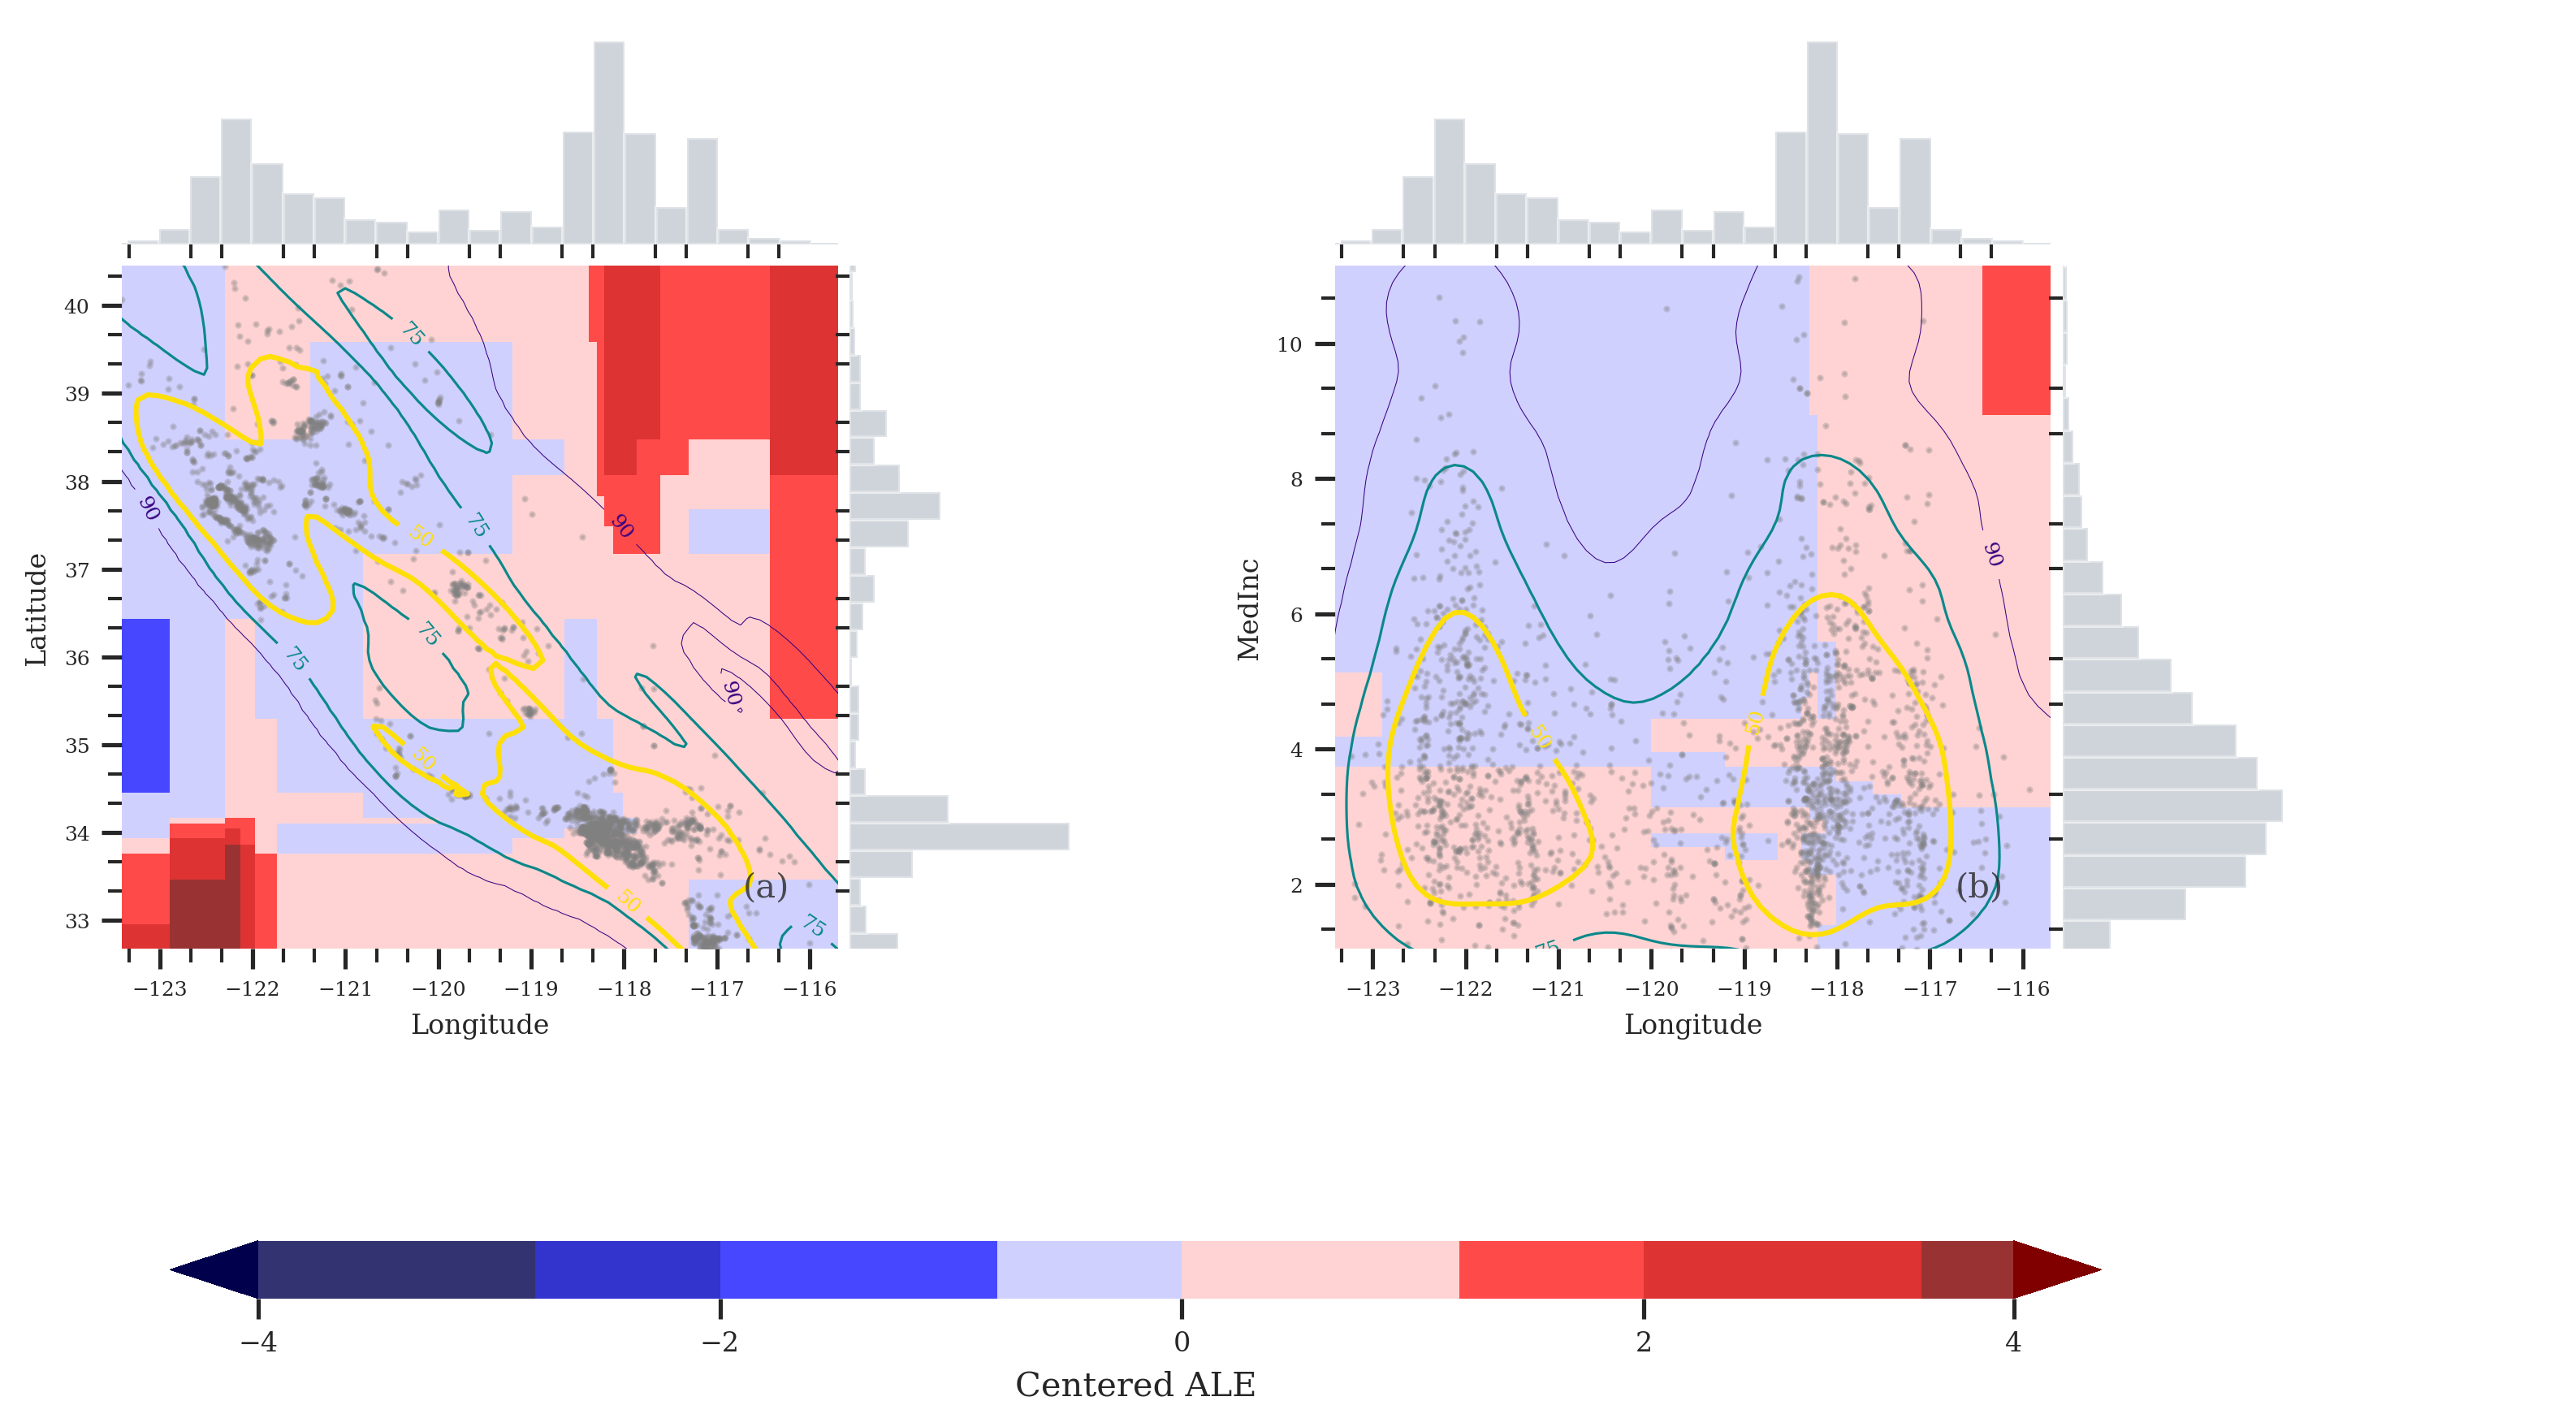

In [25]:
features = [('Longitude', 'Latitude'), ('Longitude', 'MedInc')]
ale_2d_ds = explainer.ale(features=features, 
                                 n_bootstrap=1, 
                                 subsample=1.0,
                                 n_jobs=2,
                                 n_bins=20
                                )
fig, axes = explainer.plot_ale(ale_2d_ds)

### Computing Interaction Strength 

In [26]:
ias = explainer.interaction_strength(ale_1d_reg)

  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
print(ias['Random Forest_ias'][0])

<xarray.DataArray 'Random Forest_ias' ()>
array(0.22873884)


An IAS=0.23 indicates that there is some decent feature interaction.  